In [234]:
import os
import traceback

import pandas as pd
from certa.explain import CertaExplainer
from certa.local_explain import get_original_prediction, get_row
from certa.utils import merge_sources

from baselines.landmark import Landmark
from baselines.mojito import Mojito
import shap

import json
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_colwidth = 100

In [516]:
root_datadir = '../cheapER/datasets/'
experiments_dir = '../examples/'
dataset = 'dirty_dblp_acm'
datadir = os.path.join(root_datadir, dataset)

In [517]:
lsource = pd.read_csv(datadir + '/tableA.csv')
rsource = pd.read_csv(datadir + '/tableB.csv')
gt = pd.read_csv(datadir + '/train.csv')
valid = pd.read_csv(datadir + '/valid.csv')
test = pd.read_csv(datadir + '/test.csv')

test_df = merge_sources(test, 'ltable_', 'rtable_', lsource, rsource, ['label'], [])
train_df = merge_sources(gt, 'ltable_', 'rtable_', lsource, rsource, ['label'], ['id'])

In [518]:
from models.utils import get_model
model_name = 'ditto'
save_path = 'models/saved/' + model_name + '/' + dataset
model = get_model(model_name, save_path, datadir, dataset)

* Costruzione indice degli embeddings.....Fatto. 400001 embeddings totali.
* Creazione del modello per il calcolo degli embeddings....
* Inizializzo il tokenizzatore.....Fatto: 400001 parole totali.
* Preparazione della matrice di embedding.....Fatto. Dimensioni matrice embeddings: (400002, 300)

°°° EMBEDDING MODEL °°°
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tupla_A (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
Tupla_B (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
Embedding_lookup (Embedding)    (None, None, 300)    120000600   Tupl

In [519]:
p, r, f1 = model.evaluation(test_df)
print(f1)

* Avvio test metriche....
-- Corpus size: 1916
-- Non Match: 1710
-- Match: 206
* Preparazione input......Fatto. 1916 tuple totali, esempio label: 0 -> [1. 0.], Table1 shape: (1916, 79), Table2 shape: (1916, 46)
* Evaluating: |
Precision: 0.3068181818181818, Recall: 0.13106796116504854, f1-score: 0.1836734693877551
Total retrieved: 88, retrieved/total matches: 27/206
* Avvio test metriche....
-- Corpus size: 1916
-- Non Match: 1710
-- Match: 206
* Preparazione input......Fatto. 1916 tuple totali, esempio label: 0 -> [1. 0.], Table1 shape: (1916, 79), Table2 shape: (1916, 46)
* Evaluating: |
Precision: 0.6931818181818182, Recall: 0.03567251461988304, f1-score: 0.067853170189099
Total retrieved: 88, retrieved/total no_matches: 61/1710
0.1836734693877551


In [520]:
def predict_fn(x):
    return model.predict(x)
def predict_fn_mojito(x):
    return model.predict(x, mojito=True)

In [521]:
certa_explainer = CertaExplainer(lsource, rsource)

In [523]:
predictions = model.predict(test_df)
predictions

ValueError: too many values to unpack (expected 2)

In [ ]:
false_positives = predictions.loc[(predictions['label'] == 0) & (predictions['match_score'] > 0.5)]
false_negatives = predictions.loc[(predictions['label'] == 1) & (predictions['match_score'] < 0.5)]

In [ ]:
import seaborn as sns
nm_cm = sns.light_palette("red", as_cmap=True)
m_cm = sns.light_palette("green", as_cmap=True)
cm = sns.light_palette("blue", as_cmap=True)

In [ ]:
i = 0
rand_row =  false_positives.iloc[i]
l_id = int(rand_row['ltable_id'])
label = rand_row["label"]
l_tuple = lsource.iloc[l_id]
r_id = int(rand_row['rtable_id'])
r_tuple = rsource.iloc[r_id]
rand_row.head()
label = rand_row['label']

item = get_row(l_tuple, r_tuple)
n_item = item.drop(['ltable_id','rtable_id'],axis=1)
n_item.reindex(sorted(n_item.columns), axis=1)

In [ ]:
original_prediction = false_negatives.iloc[i][['nomatch_score', 'match_score']]
original_prediction

In [ ]:
score = original_prediction[1]
score

In [ ]:
pd.DataFrame(data=[[label, score]], columns=['label','score'])

In [ ]:
pd.DataFrame(l_tuple).T

In [ ]:
pd.DataFrame(r_tuple).T

In [ ]:
saliency_df, cf_summary, counterfactual_examples, triangles = certa_explainer.explain(l_tuple, r_tuple, predict_fn, num_triangles=10)

In [ ]:
saliency_df.reindex(sorted(saliency_df.columns), axis=1).style.background_gradient(cmap=cm, axis=1, low=0.1, high=0.6)

In [ ]:
saliency_df.reindex(sorted(saliency_df.columns), axis=1).plot(kind='bar',title='certa')

In [ ]:
landmark_explainer = Landmark(lambda x: predict_fn(x)['match_score'].values, test_df,
                              lprefix='',
                              exclude_attrs=['id', 'ltable_id', 'rtable_id', 'label'],
                              rprefix='',
                              split_expression=r' ')
labelled_item = item.copy()
labelled_item['label'] = int(label)
labelled_item['id'] = i
land_explanation = landmark_explainer.explain(labelled_item)
land_exp = land_explanation.groupby('column')['impact'].sum().to_dict()

In [ ]:
pd.DataFrame(data=[land_exp.values()], columns=land_exp.keys()).reindex(sorted(land_exp.keys()), axis=1).style.background_gradient(cmap=cm, axis=1, low=0.2, high=0.6)

In [ ]:
pd.DataFrame(data=[land_exp.values()], columns=land_exp.keys()).reindex(sorted(land_exp.keys()), axis=1).plot(kind='bar',title='landmark')

In [ ]:
shap_explainer = shap.KernelExplainer(lambda x: predict_fn(x)['match_score'].values,
                                      train_df.drop(['label'], axis=1).astype(str)[:50],
                                      link='identity')
shap_instance = test_df.iloc[i, 1:].drop(['ltable_id', 'rtable_id']).astype(str)
shap_values = shap_explainer.shap_values(shap_instance, nsamples=100)
match_shap_values = shap_values
shap_saliency = dict()
for sv in range(len(match_shap_values)):
    shap_saliency[train_df.columns[1 + sv]] = match_shap_values[sv]


In [ ]:
pd.DataFrame(data=[shap_saliency.values()], columns=shap_saliency.keys()).reindex(sorted(shap_saliency.keys()), axis=1).style.background_gradient(cmap=cm, axis=1, low=0.2, high=0.6)

In [ ]:
pd.DataFrame(data=[shap_saliency.values()], columns=shap_saliency.keys()).reindex(sorted(shap_saliency.keys()), axis=1).plot(kind='bar',title='shap')

In [ ]:
mojito = Mojito(test_df.columns,
                attr_to_copy='left',
                split_expression=" ",
                class_names=['no_match', 'match'],
                lprefix='', rprefix='',
                feature_selection='lasso_path')
mojito_exp = mojito.drop(predict_fn_mojito, item,
                              num_features=30,
                              num_perturbation=100)
mojito_exp = mojito_exp.groupby('attribute')['weight'].mean().to_dict()
for f in item.columns:
    if not f in mojito_exp.keys():
        mojito_exp[f] = 0
if 'id' in mojito_exp:
    mojito_exp.pop('id', None)
if 'ltable_id' in mojito_exp:
    mojito_exp.pop('ltable_id', None)
if 'rtable_id' in mojito_exp:
    mojito_exp.pop('rtable_id', None)

In [ ]:
pd.DataFrame(data=[mojito_exp.values()], columns=mojito_exp.keys()).reindex(sorted(mojito_exp.keys()), axis=1).style.background_gradient(cmap=cm, axis=1, low=0.2, high=0.6)

In [ ]:
pd.DataFrame(data=[mojito_exp.values()], columns=mojito_exp.keys()).reindex(sorted(mojito_exp.keys()), axis=1).plot(kind='bar',title='mojito')

In [ ]:
import random

null_hyp = dict()
for r in n_item.columns:
    null_hyp[r] = random.uniform(-1, 1)
null_hyp_saliency_df = pd.DataFrame(data=[null_hyp.values()], columns=null_hyp.keys())
null_hyp_saliency_df.reindex(sorted(null_hyp.keys()), axis=1).style.background_gradient(cmap=cm, axis=1, low=0.2, high=0.6)

In [ ]:
null_hyp_saliency_df.reindex(sorted(null_hyp.keys()), axis=1).plot(kind='bar',title='null')

In [ ]:
certa_e = saliency_df.copy().to_dict(orient='list')
certa_e['type'] = 'certa'
mojito_e = mojito_exp.copy()
mojito_e['type'] = 'mojito'
land_e = land_exp.copy()
land_e['type'] = 'landmark'
shap_e = shap_saliency.copy()
shap_e['type'] = 'shap'
null_e = null_hyp.copy()
null_e['type'] = 'null'

In [ ]:
def eig(explanation, agg=True):
    print(explanation)
    saliency = explanation.copy()
    exp_type = saliency['type']
    print(saliency.pop('type'))
    scores_d = []
    scores_c = []
    scores = []
    lt = l_tuple.copy()
    rt = r_tuple.copy()
    row = get_row(lt, rt)
    orig = predict_fn(row)[['nomatch_score', 'match_score']].values[0][1]
    for tk in np.arange(8):
        scores.append(orig)
        # get top k important attributes
        if not agg and tk >= len(saliency):
            break
        if exp_type == 'certa':
            if agg:
                explanation_attributes = sorted(saliency, key=saliency.get, reverse=True)[:tk]
            else:
                explanation_attributes = [sorted(saliency, key=saliency.get, reverse=True)[tk]]
        elif score < 0.5:
            saliency = {k:v for k,v in saliency.items() if v < 0}
            if agg:
                explanation_attributes = sorted(saliency, key=saliency.get)[:tk]
            else:
                explanation_attributes = [sorted(saliency, key=saliency.get)[tk]]
        else:
            saliency = {k:v for k,v in saliency.items() if v > 0}
            if agg:
                explanation_attributes = sorted(saliency, key=saliency.get, reverse=True)[:tk]
            else:
                explanation_attributes = [sorted(saliency, key=saliency.get, reverse=True)[tk]]
        print(explanation_attributes)
        # change those attributes
        try:
            lt = l_tuple.copy()
            rt = r_tuple.copy()
            modified_row = get_row(lt, rt)
            for e in explanation_attributes:
                modified_row[e] = ''
            modified_tuple_prediction = predict_fn(modified_row)[['nomatch_score', 'match_score']].values[0]
            #print(modified_tuple_prediction)
            #print(modified_row)
            score_drop = modified_tuple_prediction[1]
            
            scores_d.append(score_drop)
        except Exception as e:
            print(traceback.format_exc())
        try:
            lt = l_tuple.copy()
            rt = r_tuple.copy()
            modified_row = get_row(lt, rt)
            for e in explanation_attributes:
                if e.startswith(lprefix):
                    new_e = e.replace(lprefix, rprefix)
                else:
                    new_e = e.replace(rprefix, lprefix)
                modified_row[e] = modified_row[new_e]
            #print(modified_row)
            modified_tuple_prediction = predict_fn(modified_row)[['nomatch_score', 'match_score']].values[0]
            #print(modified_tuple_prediction)
            score_copy = modified_tuple_prediction[1]
            scores_c.append(score_copy)
        except Exception as e:
            print(traceback.format_exc())
    pd.Series(scores_d,name='drop').plot(kind='line', ylim=(0.45,0.55), title=exp_type)
    #pd.Series(scores_c,name='copy').plot(kind='line', ylim=(0.45,0.55), title=exp_type)
    pd.Series(scores,name='pred').plot(kind='line', ylim=(0.45,0.55), title=exp_type)

{'ltable_title': [0.5338983050847457], 'ltable_authors': [0.49152542372881347], 'ltable_venue': [0.49999999999999994], 'ltable_year': [0.49152542372881347], 'rtable_title': [0.20338983050847462], 'rtable_authors': [0.18644067796610173], 'rtable_venue': [0.18644067796610173], 'rtable_year': [0.18644067796610173], 'type': 'certa'}
certa
[]
['ltable_title']
['ltable_title', 'ltable_venue']
['ltable_title', 'ltable_venue', 'ltable_authors']
['ltable_title', 'ltable_venue', 'ltable_authors', 'ltable_year']
['ltable_title', 'ltable_venue', 'ltable_authors', 'ltable_year', 'rtable_title']
['ltable_title', 'ltable_venue', 'ltable_authors', 'ltable_year', 'rtable_title', 'rtable_authors']
['ltable_title', 'ltable_venue', 'ltable_authors', 'ltable_year', 'rtable_title', 'rtable_authors', 'rtable_venue']


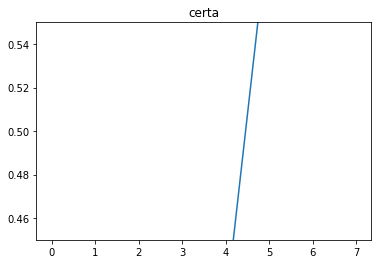

In [526]:
eig(certa_e, agg=True)